In [3]:
# See whether GPU is available
import numpy as np
import xgboost as xgb

# Pre-processing
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

# LHE
from skimage.morphology import disk
from skimage.filters.rank import equalize

# HOG, Canny Edge
from skimage.feature import hog,canny
from skimage.exposure import rescale_intensity

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# Validating
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb

In [5]:
def getImgPaths(imgsRoot="/home/inze/ipsoot/"):
    imgNames=[q.name for q in os.scandir(imgsRoot) if q.name[q.name.find(".")+1:] in ("jpg","jpeg","png")]
    imgPaths=[imgsRoot+imgNames for imgNames in imgNames]
    return imgPaths

imgPaths=getImgPaths("d:/dnld/ipsoot/")

In [6]:
def readImgs(imgPaths,limit=None,size=(100,100)):
    limit = len(imgPaths) if limit is None else limit
    imgs=[(resize(imread(ip,as_gray=True),size)*255).astype(np.uint8) for ip in imgPaths[:limit-1]]
    imgsSize=sum([img.nbytes for img in imgs])
    print(f"{imgsSize/1024/1024:.2f}","MiB")
    return imgs

imgs=readImgs(imgPaths)

9.58 MiB


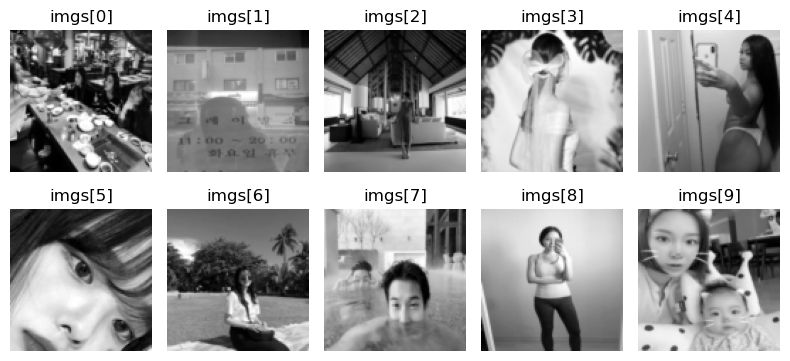

In [7]:
def showImgs(imgs,labels=None):
    labels = labels if labels else [f"imgs[{n}]" for n in range(len(imgs))]
    fig=plt.figure(figsize=(8,4))
    for q in range(10):
        fig.add_subplot(2,5,q+1)
        plt.imshow(imgs[q],cmap="gray")
        plt.title(f"{labels[q]}")
        plt.axis("off")
        plt.tight_layout()

showImgs(imgs)

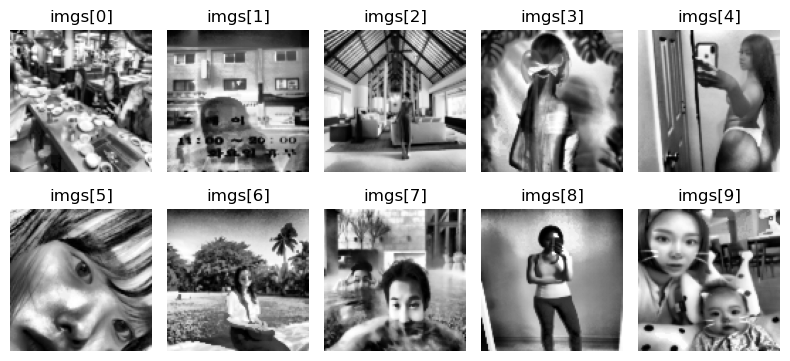

In [8]:
def lhe(imgs,footprint=30):
    footprint=disk(footprint)
    imgsLHE=[equalize(img,footprint=footprint) for img in imgs]
    return imgsLHE

imgsLHE=lhe(imgs)
showImgs(imgsLHE)

In [22]:
def getImgsHog(imgs):
    imgsHog=[]
    for feature,img in [hog(img,pixels_per_cell=(8,8),cells_per_block=(3,3),visualize=True) for img in imgs]:
        imgsHog.append([(feature*255).astype(np.uint8),img])
    return imgsHog

def getImgsEdge(imgs):
    imgsEdge=[canny(img,sigma=3).astype(np.uint8) for img in imgs]
    return imgsEdge

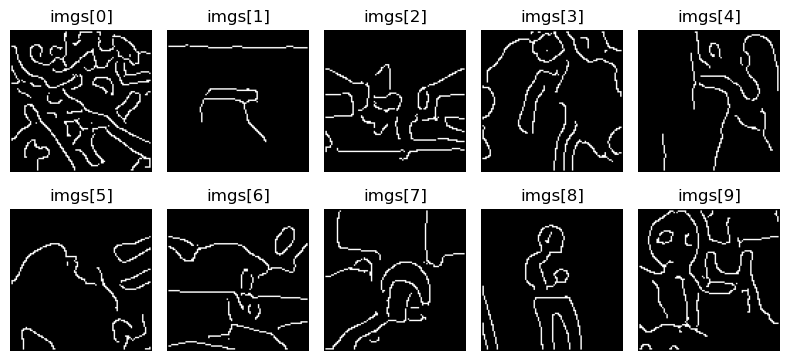

In [23]:
imgsEdge=getImgsEdge(imgs)
showImgs(imgsEdge)

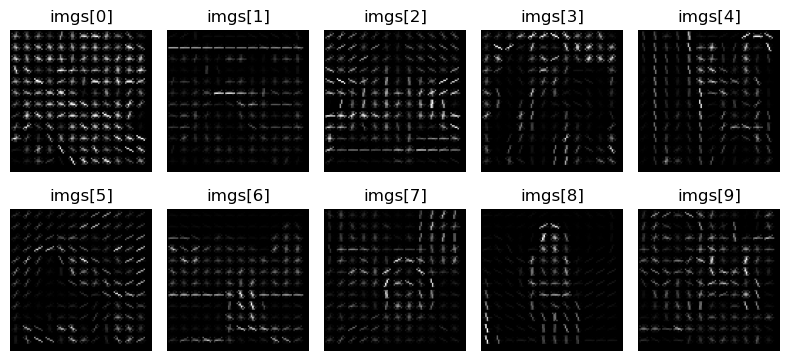

In [15]:
imgsHog=getImgsHog(imgs)
showImgs([rescale_intensity(q[1],in_range=(0,50)) for q in imgsHog[:10]])

In [25]:
print(f"{(sum([q[0].nbytes for q in imgsHog]))/1024/1024:.2f}","MiB of footprint")
print(f"{(sum([q[0].nbytes for q in imgsEdge]))/1024/1024:.2f}","MiB of footprint")

7.76 MiB of footprint
0.10 MiB of footprint


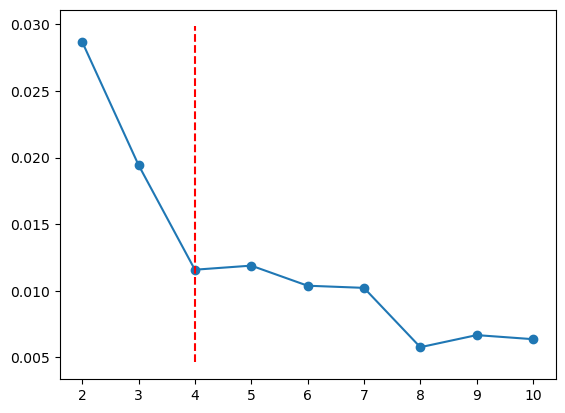

In [17]:
def getClusterCount(features,rng=(2,11)):
    clusterMetrics=[]
    for n in range(rng[0],rng[1]):
        clusterer=KMeans(n_clusters=n,random_state=23301522).fit(features)
        metric=silhouette_score(features,clusterer.labels_)
        clusterMetrics.append(metric)

    plt.plot(range(rng[0],rng[1]), clusterMetrics, marker="o")
    ymin,ymax=plt.ylim()
    knee=KneeLocator(range(rng[0],rng[1]),clusterMetrics,curve="convex",direction="decreasing")
    plt.vlines(knee.elbow,ymin=ymin,ymax=ymax,color="red",linestyle="dashed")
    return knee.elbow

clusterCount=getClusterCount([q[0] for q in imgsHog])

In [18]:
clusterer=KMeans(n_clusters=5,random_state=23301522).fit([q[0] for q in imgsHog])

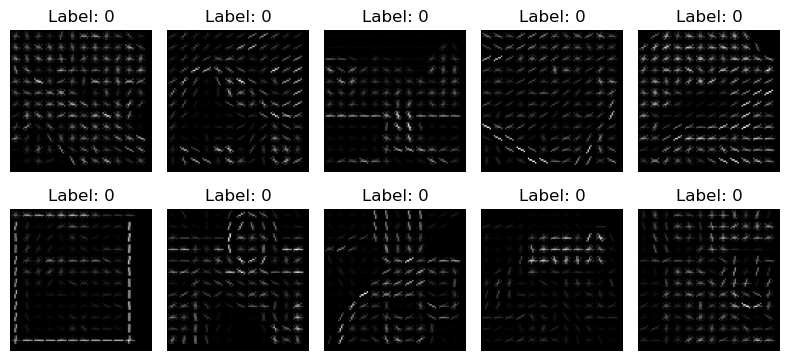

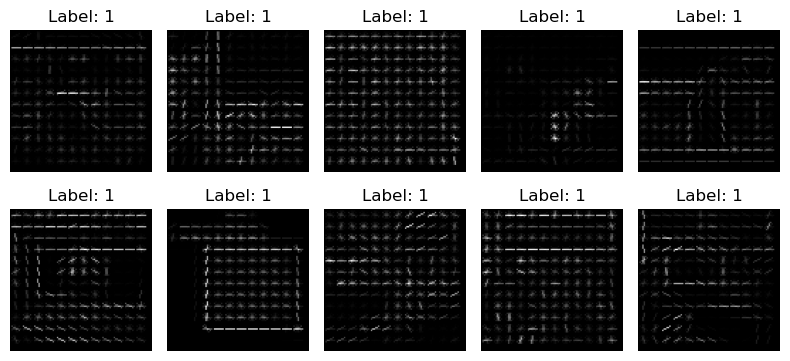

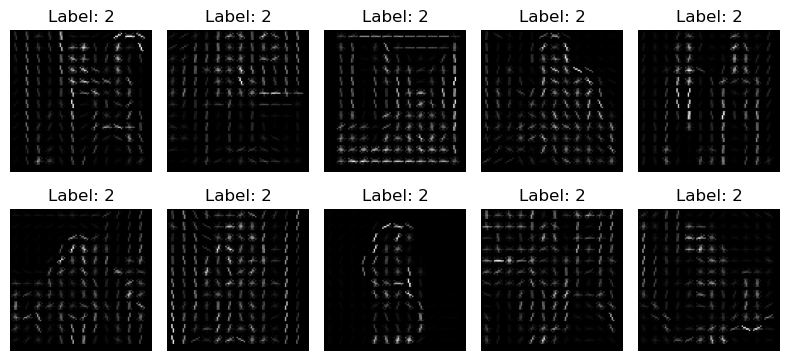

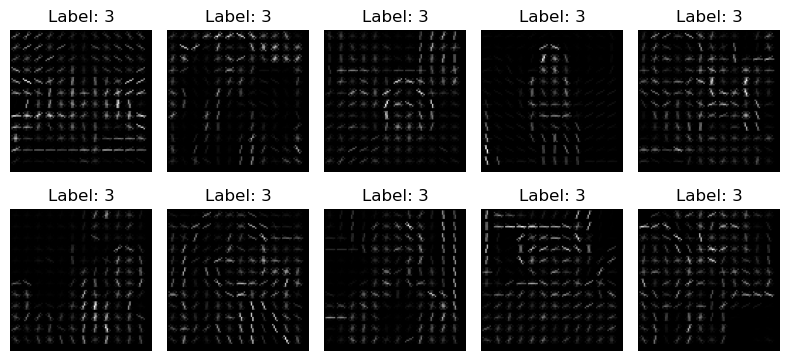

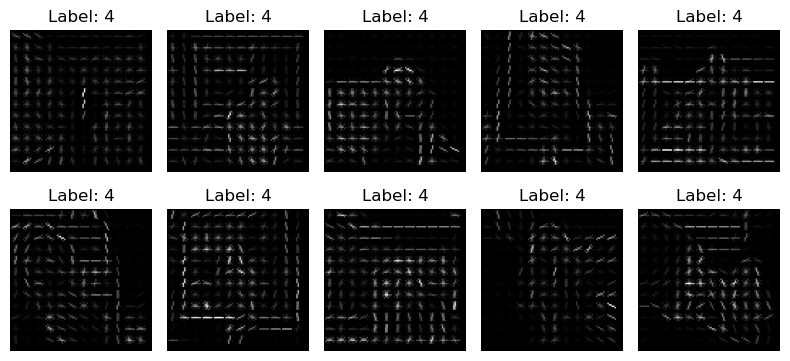

In [19]:
def showLabeledImgs(imgs,labels):
    l=0
    while l<np.max(labels)+1:
        imgsGroupBy=[]
        for i in range(len(labels)):
            if labels[i]==l:
                imgsGroupBy.append(imgs[i])
        showImgs(imgsGroupBy,[f"Label: {l}" for q in range(len(imgsGroupBy))])
        l+=1

showLabeledImgs([q[1] for q in imgsHog],clusterer.labels_)

In [26]:
splitter=ShuffleSplit(
    n_splits=10,
    random_state=23301522
)
estimator=xgb.XGBClassifier()

from sklearn.model_selection import RandomizedSearchCV

params={
    "tree_method":["hist"],
    "device":["cuda"],
    "enable_categorical":[True],
    "sampling_method":["gradient_based"],
    "eta":np.linspace(.1,1,5),
    "max_depth":[6],
    "lambda":np.logspace(0,1.5,5),
    "subsample":[.2],
}

validator=RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    scoring="f1_micro",
    cv=splitter,
    random_state=23301522,
    verbose=2,
)

x=np.asarray([q[0] for q in imgsHog])
y=clusterer.labels_.astype(np.uint8)

validator.fit(x,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\prog\lib\conda\envs\o\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:17:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END device=cuda, enable_categorical=True, eta=0.775, lambda=31.622776601683793, max_depth=6, sampling_method=gradient_based, subsample=0.2, tree_method=hist; total time=  21.1s
[CV] END device=cuda, enable_categorical=True, eta=0.775, lambda=31.622776601683793, max_depth=6, sampling_method=gradient_based, subsample=0.2, tree_method=hist; total time=  20.7s
[CV] END device=cuda, enable_categorical=True, eta=0.775, lambda=31.622776601683793, max_depth=6, sampling_method=gradient_based, subsample=0.2, tree_method=hist; total time=  20.9s
[CV] END device=cuda, enable_categorical=True, eta=0.775, lambda=31.622776601683793, max_depth=6, sampling_method=gradient_based, subsample=0.2, tree_method=hist; total time=  20.6s
[CV] END device=cuda, enable_categorical=True, eta=0.775, lambda=31.622776601683793, max_depth=6, sampling_method=gradient_based, subsample=0.2, tree_method=hist; total time=  20.7s
[CV] END device=cuda, enable_categorical=True, eta=0.775, lambda=31.622776601683793, max_d

RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=23301522, test_size=None,
       train_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gro...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'device': ['cuda'],
                                        'enable_categorical': [True],
                                        'eta': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'lambda': array([ 1.        ,  2.37137371,  5.62341325, 13.33521432, 31.6227766 ]),
                                        'max_depth': [6],
                                        'sampling_method': ['gradient_based'],
                                        'subsample': [0.2],
                                        'tree_method': ['hist']},
                   random_state=23301522, scoring='f1_micro', verbose=2)

In [12]:
def getBestEstimator(validator):
    print("Score: ",f"{validator.best_score_:.2f}","\n","Params: ",validator.best_params_)
    return validator.best_estimator_

bestEstimator=getBestEstimator(validator)
bestEstimator

Score:  0.78 
 Params:  {'tree_method': 'hist', 'subsample': 0.2, 'sampling_method': 'gradient_based', 'max_depth': 6, 'lambda': 2.371373705661655, 'eta': 0.1, 'enable_categorical': True, 'device': 'cuda'}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=2.371373705661655, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [13]:
bestEstimator.save_model("./model.json")